In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

In [2]:
def show_image(label, image_row, s):
    image_matrix = np.array(image_row.reshape(s,s), dtype=np.int32)
    image = Image.fromarray(image_matrix)
    print('Реальная цифра =', label)
    image.show()

In [3]:
def getLabeledSubset(full_set, subset_size):
    df_labeled = full_set[full_set['label'].notna()]
    if subset_size is None:
        return df_labeled
    indexes = np.random.choice(list(range(df_labeled.shape[0])), 
                               size=min(subset_size, df_labeled.shape[0]), 
                               replace=False)
    return full_set.iloc[indexes]

In [4]:
def runModel(df, model):
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    model.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    print(classification_report(y_test, y_predict))

In [2]:
#Загрузка обучающего DataSet
full_df = pd.concat([pd.read_csv('train.csv'), pd.read_csv('test.csv')], axis=0, ignore_index=True)

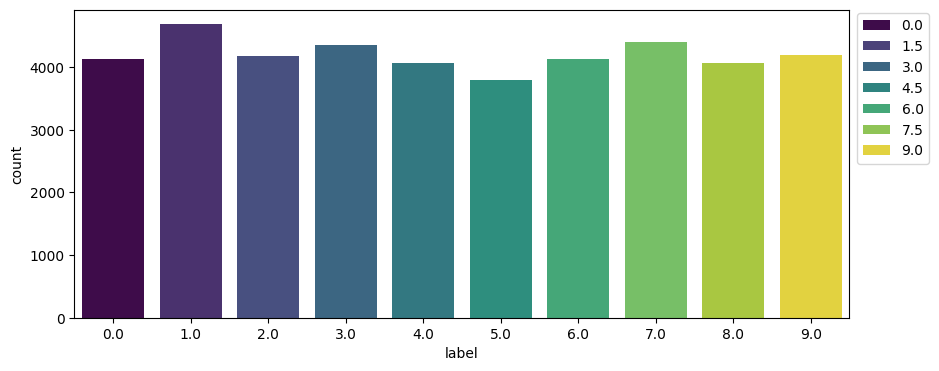

In [6]:
#Классы сбалансированы
plt.figure(figsize=(10,4), dpi=100)
sns.countplot(full_df, x='label', hue='label', palette='viridis')
plt.legend(loc=(1.01, 0.5))

In [3]:
#Удаляем полностью нулевые столбцы
full_df = full_df.drop(full_df.columns[np.sum(full_df, axis=0)==0], axis=1)

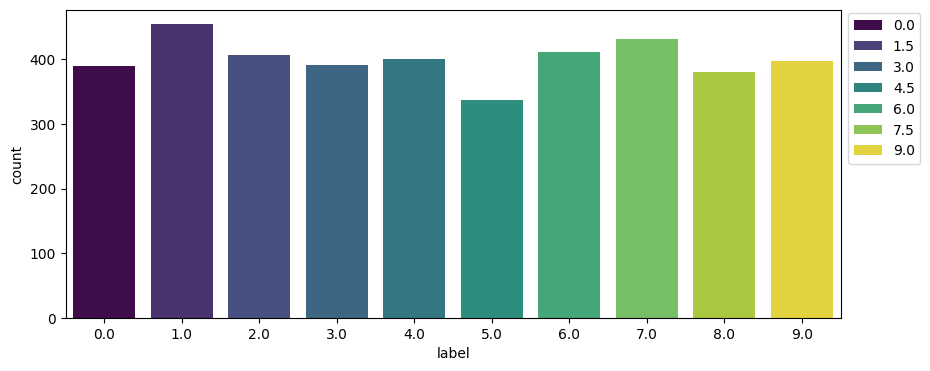

In [71]:
#Для поиска модели будем использовать не весь DataSet, а только часть случайно выбранных объектов
subset_size = 4000
df_subset = getLabeledSubset(full_df, subset_size)
plt.figure(figsize=(10,4), dpi=100)
sns.countplot(df_subset, x='label', hue='label', palette='viridis')
plt.legend(loc=(1.01, 0.5))

In [ ]:
#1. С уменьшением размерности

C:\Users\Maksim\AppData\Local\Temp\ipykernel_8284\3913769156.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  result.append(np.float16(numerator/full_sum))


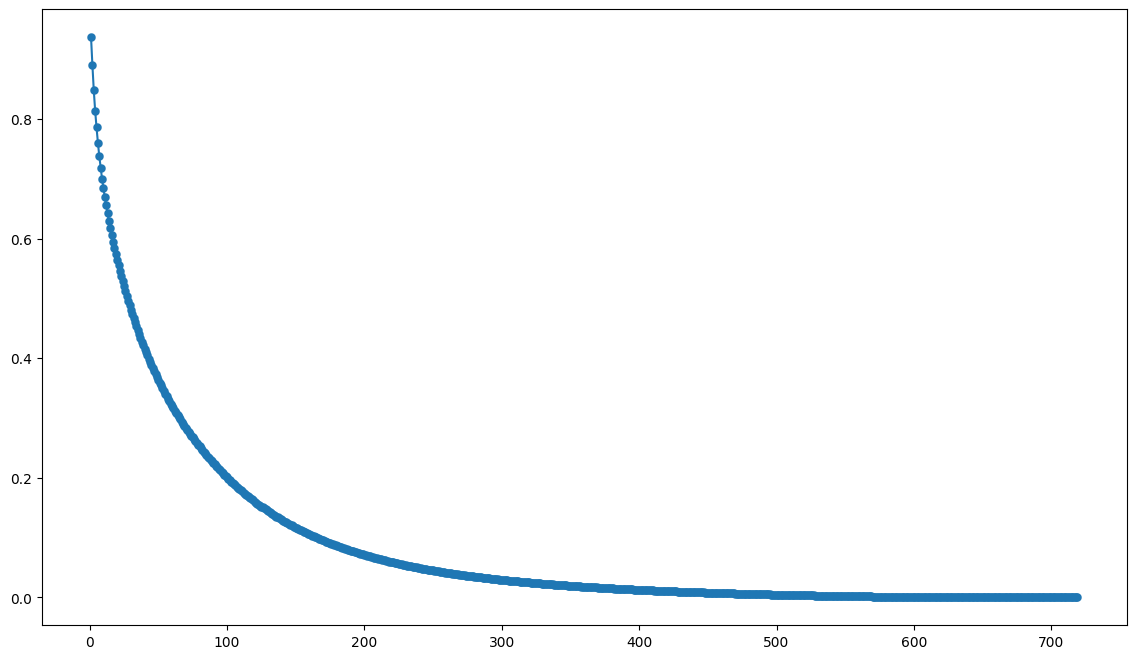

In [34]:
#Поиск оптимального кол-ва компонент
X_for_eigvals = df_subset.drop('label', axis=1)
scaler_for_eigvals = StandardScaler()
X_for_eigvals = scaler_for_eigvals.fit_transform(X_for_eigvals)

eigvals = np.linalg.eigvals(X_for_eigvals.T @ X_for_eigvals)
sorted_eigvals = np.sort(eigvals)[::-1]
full_sum = np.sum(sorted_eigvals)

result = []
M_start, M_end = 1, 1000
numerator = full_sum
for m in range(M_start, min(M_end, eigvals.shape[0])+1):
    numerator -= sorted_eigvals[m-1]
    result.append(np.float16(numerator/full_sum))
plt.figure(figsize=(14,8), dpi=100)
plt.plot(range(M_start, min(M_end, eigvals.shape[0])+1), result, '-o', mew=0.1)

In [10]:
#Метод опорных векторов
svc_scaler = StandardScaler()
svc_pca = PCA(n_components=45)
svc_model = SVC(C=17, kernel='rbf')
svc_pipe = Pipeline([('scaler', svc_scaler),('pca', svc_pca),('model', svc_model)])
df_check = getLabeledSubset(full_df, None)
runModel(df_check, svc_pipe)

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98       789
         1.0       0.99      0.98      0.99       948
         2.0       0.97      0.98      0.98       859
         3.0       0.97      0.97      0.97       859
         4.0       0.97      0.98      0.98       818
         5.0       0.97      0.97      0.97       733
         6.0       0.98      0.99      0.98       824
         7.0       0.97      0.97      0.97       873
         8.0       0.97      0.96      0.97       820
         9.0       0.98      0.95      0.96       877

    accuracy                           0.97      8400
   macro avg       0.97      0.98      0.97      8400
weighted avg       0.98      0.97      0.97      8400



In [37]:
#Метод ближайших соседей
knn_scaler = StandardScaler()
knn_pca = PCA(n_components=50)
knn_model = KNeighborsClassifier(n_neighbors=4)
knn_pipe = Pipeline([('scaler', knn_scaler),('pca', knn_pca),('model', knn_model)])
df_check = getLabeledSubset(full_df, None)
runModel(df_check, knn_pipe)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       789
         1.0       0.97      0.99      0.98       948
         2.0       0.96      0.96      0.96       859
         3.0       0.94      0.94      0.94       859
         4.0       0.94      0.97      0.95       818
         5.0       0.93      0.93      0.93       733
         6.0       0.97      0.98      0.98       824
         7.0       0.96      0.95      0.95       873
         8.0       0.95      0.92      0.94       820
         9.0       0.94      0.90      0.92       877

    accuracy                           0.95      8400
   macro avg       0.95      0.95      0.95      8400
weighted avg       0.95      0.95      0.95      8400



In [32]:
#AdaBoost
ada_pca = PCA(n_components=50)
ada_model = AdaBoostClassifier(n_estimators=470)
ada_pipe = Pipeline([('pca', ada_pca),('model', ada_model)])
df_check = getLabeledSubset(full_df, None)
runModel(df_check, ada_pipe)

              precision    recall  f1-score   support

         0.0       0.90      0.83      0.86       789
         1.0       0.90      0.97      0.93       948
         2.0       0.84      0.70      0.77       859
         3.0       0.76      0.70      0.73       859
         4.0       0.75      0.73      0.74       818
         5.0       0.63      0.66      0.65       733
         6.0       0.86      0.87      0.87       824
         7.0       0.83      0.74      0.78       873
         8.0       0.68      0.79      0.73       820
         9.0       0.58      0.68      0.63       877

    accuracy                           0.77      8400
   macro avg       0.78      0.77      0.77      8400
weighted avg       0.78      0.77      0.77      8400



In [76]:
#Итоговая модель - SVC

In [4]:
#Нормализация данных
X_full = full_df.drop('label', axis=1)
y_full = full_df['label']
scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full)

In [5]:
#Уменьшение размерности
pca = PCA(n_components=45)
X_full_pca = pca.fit_transform(X_full_scaled)

In [7]:
#Разделение на Test и Train
X_train = X_full_pca[y_full.notna()]
y_train = y_full[y_full.notna()]
X_test = X_full_pca[y_full.isna()]

In [9]:
#Обучение модели
model = SVC(C=17, kernel='rbf')
model.fit(X_train, y_train)

SVC(C=17)

In [10]:
y_predict = model.predict(X_test)

In [32]:
result = pd.DataFrame(np.arange(1, y_predict.shape[0]+1), columns=['ImageId'])
result['Label'] = y_predict.astype('int64')

In [33]:
result.to_csv('result.csv', index=False)